In [1]:
#params:
metCut = 0
cutLogg = True
norm = False
save = None
monteCut = None
nMonte = 1
customCol = False
colours =  ['g_fpsf-r_fpsf', 'g_fpsf-i_fpsf', 'CaHK_0-g_fpsf', 'CaHK_0-r_fpsf']
FeH = 'fehannrr'


norm = norm if monteCut == None else False
import re
from metaimports import *
from ZNN import ZNN
from modelValidator import psMetric, cut, shuffleDwarfs, plotRes, plot, norm_inputs, monte_carlo
from sklearn.neural_network import MLPRegressor
from matplotlib.pyplot import figure
from fitsParser import fitsParser
fits = fitsParser(includefile = 'FeHdata.txt')
cut(fits)

fits.data = fits.data[(fits.data['u_0-CaHK_0']>0.33)|(fits.data['CaHK_0-g_fpsf']>0.3)]
save_data(fits.data, 'filtered.ascii')

if cutLogg:
    #dwarfs = fits.data
    dwarfs = (fits.data.sample(frac = 1, random_state = int(1000*np.random.rand()))).reset_index(drop = True)
    dwarfs = dwarfs[dwarfs['logg']>3.5]
else:
    dwarfs = shuffleDwarfs(fits)

if customCol:
    fits.colours = colours
    
metPoorDwarfs = dwarfs[dwarfs[FeH]<metCut]
metRichDwarfs = dwarfs[dwarfs[FeH]>metCut]
din = metPoorDwarfs[fits.colours]
if norm:
    normParams = norm_inputs(din)
dout = metPoorDwarfs[FeH]
din_train, din_test, dout_train, dout_test = train_test_split(din,dout, test_size = 0.2, shuffle = False)
#din_train = din_train.sample(frac = 1, random_state = int(1000*np.random.rand()))


Using TensorFlow backend.



Data saved

condition on dg_fpsf cut 22 inputs
condition on dr_fpsf cut 23 inputs
condition on di_fpsf cut 6 inputs
condition on dz_fpsf cut 2 inputs
condition on dy_fpsf cut 14 inputs
condition on dCaHK_0 cut 14 inputs
condition on du_0 cut 158 inputs
condition on dFeHadop cut 280 inputs
10.66% of inputs cut

Data saved



In [2]:

def monte(din, N=-2):
    tous = dwarfs.loc[din.index]
    uncert = pd.DataFrame()
    for col in fits.colours:
        c1 = 'd'+re.compile('.+(?=-)').findall(col)[0]
        c2 = 'd' + re.compile('(?<=-).+').findall(col)[0]
        uncert[col] = np.sqrt(tous[c1]**2+tous[c2]**2)

    uncert[map(lambda x : x[1:], fits.output_uncert)] = tous[fits.output_uncert]
    return monte_carlo(tous[list(fits.colours+fits.outputs)],uncert ,N=N)
        


In [3]:
params = {
    'hidden_layer_sizes' : (16,16,16,16,16),
    'batch_size' : 50,
    'verbose' : False,
    'tol' : 0.00001
}
#model = jb.load('mightWork.jb')
model = MLPRegressor(**params)

if monteCut!=None:
    tous = dwarfs.loc[din.index]
    #print monte(din[tous['FeHadop']<monteCut], N = nMonte)
    mcSample = pd.concat([tous , monte(din[tous['FeHadop']<monteCut], N = nMonte)], axis = 0, sort = True)
    train_x = mcSample[fits.colours]
    train_y = mcSample[fits.outputs]
    
else:
    train_x = din_train
    train_y = dout_train
print 'training on ' +str(len(train_x))+' data points'
print 'inputs: '+str(list(train_x.keys()))
model.fit(train_x, np.ravel(np.array(train_y)))

training on 23441 data points
inputs: ['u_0-CaHK_0', 'u_0-g_fpsf', 'CaHK_0-g_fpsf', 'CaHK_0-r_fpsf', 'g_fpsf-r_fpsf', 'g_fpsf-i_fpsf', 'r_fpsf-i_fpsf', 'r_fpsf-z_fpsf', 'i_fpsf-z_fpsf', 'i_fpsf-y_fpsf', 'z_fpsf-y_fpsf']


MLPRegressor(activation='relu', alpha=0.0001, batch_size=50, beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(16, 16, 16, 16, 16), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=1e-05,
       validation_fraction=0.1, verbose=False, warm_start=False)

True


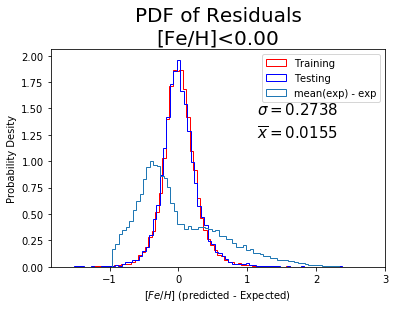

In [4]:
getbins = lambda data, size = 0.1 : np.arange(min(data), max(data) + size, size)
metPoorDwarfs['test_flag'] = np.append(np.zeros(len(din_train)),np.ones(len(din_test)))
metRichDwarfs['test_flag'] = [-1]*len(metRichDwarfs)
outputSDSS = metPoorDwarfs.append(metRichDwarfs).sort_index()
check = filter(lambda x : x != 'test_flag' , outputSDSS.keys())
print len(outputSDSS) == len(dwarfs)
assert (outputSDSS[check] == dwarfs).all().all()
inp = outputSDSS[fits.colours]

if norm:
    for field in fits.colours:
        inp[field] = (inp[field] - normParams[field][0])*1.0/normParams[field][1]
        
outputSDSS['FeH_pred'] = model.predict(inp)
outputSDSS['res'] = outputSDSS['FeH_pred'] - outputSDSS[FeH]
outputSDSS = outputSDSS.reset_index()
x = plotRes((outputSDSS['res'])[outputSDSS['test_flag']==1], (outputSDSS['res'])[outputSDSS['test_flag']==0], metLabel = '[Fe/H]<%.2f'%metCut, size = 0.05,
       xy = (257, 195) , normalFit  = False)
toPlot = (outputSDSS[outputSDSS[FeH]<metCut])[FeH]
toPlot -= np.mean(toPlot)
toPlot *= -1
plt.hist(toPlot, histtype = 'step' , bins = getbins(toPlot, size = 0.05), density = True, label = 'mean(exp) - exp')
plt.legend()
plt.show()

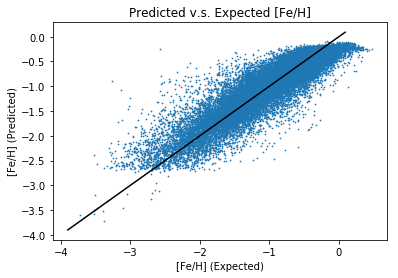

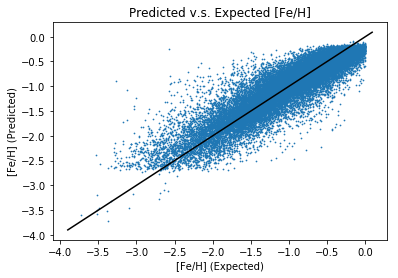

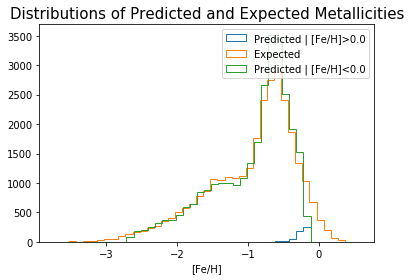

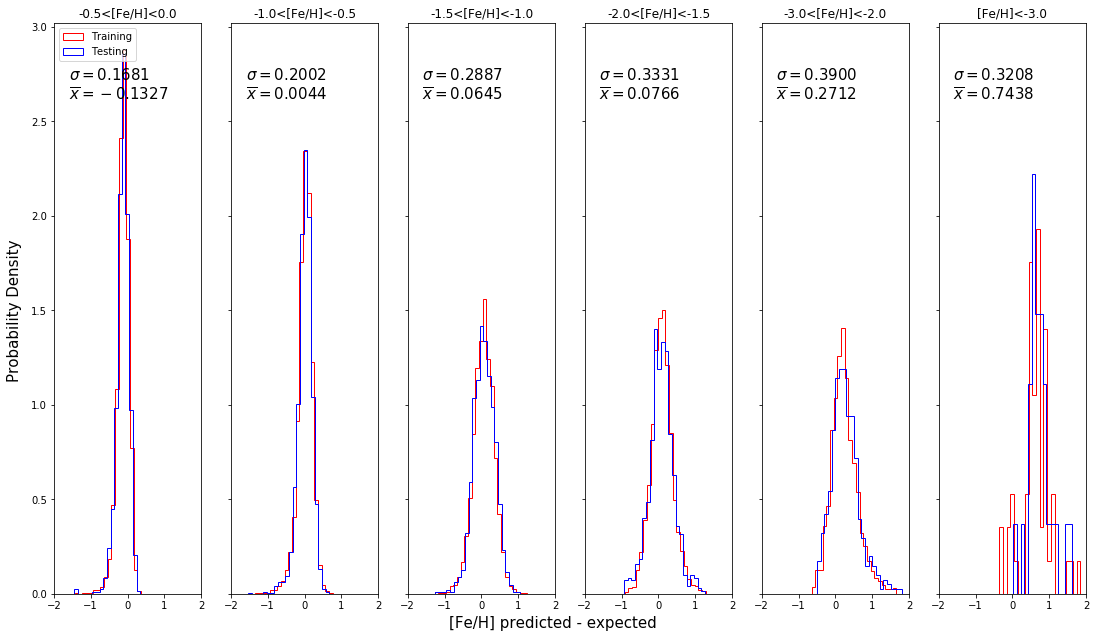

In [5]:
def makePlots(outputSDSS, pred = 'FeH_pred', adop = FeH, res ='res'):
    #plot((outputSDSS[res])[outputSDSS['test_flag']==-1])

    plt.scatter(outputSDSS[adop], outputSDSS[pred] , s = 0.5)
    plt.title('Predicted v.s. Expected [Fe/H]')
    plt.xlabel('[Fe/H] (Expected)')
    plt.ylabel('[Fe/H] (Predicted)')
    x = np.linspace(max((plt.xlim())[0], (plt.ylim())[0]), min((plt.xlim())[1], (plt.ylim())[1]))
    plt.plot(x,x, color = 'black')
    plt.show()

    plt.scatter((outputSDSS[outputSDSS[adop]<metCut])[adop], (outputSDSS[outputSDSS[adop]<metCut])[pred] , s = 0.5)
    plt.title('Predicted v.s. Expected [Fe/H]')
    plt.xlabel('[Fe/H] (Expected)')
    plt.ylabel('[Fe/H] (Predicted)')
    x = np.linspace(max((plt.xlim())[0], (plt.ylim())[0]), min((plt.xlim())[1], (plt.ylim())[1]))
    plt.plot(x,x, color = 'black')
    plt.show()


    getbins = lambda data, size = 0.1 : np.arange(min(data), max(data) + size, size)
    den = False
    getNbins = lambda data, s ,size = 0.1 : int((np.max(data[s])-np.min(data[s]))/size)
    try:
        plt.hist((outputSDSS[pred])[outputSDSS['test_flag']==-1], bins  = getbins((outputSDSS[pred])[outputSDSS['test_flag']==-1]),  histtype = 'step', label = 'Predicted | [Fe/H]>%.1f'%metCut, density = den)
    except ValueError:
        pass
    plt.hist((outputSDSS[adop]), bins = getbins((outputSDSS[adop])), histtype = 'step', label = 'Expected', density = den)
    plt.hist((outputSDSS[pred])[outputSDSS['test_flag']>=0], bins=getbins((outputSDSS[pred])[outputSDSS['test_flag']>=0]),  histtype = 'step', label = 'Predicted | [Fe/H]<%.1f'%metCut, density = den)
    plt.xlabel('[Fe/H]')
    plt.title('Distributions of Predicted and Expected Metallicities', fontsize = 15)
    plt.legend(loc = 'upper right')
    plt.show()


    bins = [0, -0.5, -1,-1.5, -2 , -3]
    f,  z = plt.subplots(1, len(bins), sharex='all', sharey='row')
    plt.xlim(-2,2)
    f.set_size_inches(18.5, 10.5)
    for i in range(len(bins)):
        if (i==len(bins)-1):
            sub = outputSDSS[outputSDSS[adop]<bins[i]]
        else:
            sub = outputSDSS[(outputSDSS[adop]<bins[i])&(outputSDSS[adop]>bins[i+1])]
        Title = '%.1f<[Fe/H]<%.1f' %(bins[i+1] ,bins[i]) if i+1 in range(len(bins)) else '[Fe/H]<%.1f'%bins[i]
        plotRes((sub[sub['test_flag']!=0])[res], (sub[sub['test_flag']==0][res]), toPlot = z[i],title = Title, normalFit = False, xy = (0.1 , 0.9))
    z[0].legend(loc = 'upper left')
    f.text(0.5, 0.08, '[Fe/H] predicted - expected', ha='center', fontsize = 15)
    f.text(0.09, 0.5, 'Probability Density', va='center', rotation='vertical', fontsize = 15)
    plt.show()

makePlots(outputSDSS)

In [6]:
inc = [-1, -1.5 , -2, -2.5 ,-3]
pur , com = psMetric(outputSDSS, inc = inc)
def printTable(inc, pur, com):
    table = ""
    table += '| [Fe/H]< | purity | completness |'
    table += '\n'+'-'*len(table)+'\n'
    for i in range(len(inc)):
        if pur[i]>=0:
            table+= '| %-8.1f| %6.4f | %-11.4f |\n'%(inc[i],pur[i],com[i])
        else: table+= '| %-8.1f| %5.3f | %-11.4f |\n'%(inc[i],pur[i],com[i])
    return table

print printTable(inc,pur,com)

print 'For only stars with [Fe/H]<%d:\n'%metCut
pur1, com1 = psMetric(outputSDSS[outputSDSS[FeH]<metCut], inc=inc)
print printTable(inc, pur1, com)
print 'For all stars not trained on'
pur2,com2 = psMetric(outputSDSS[outputSDSS['test_flag']!=0], inc = inc)
print printTable(inc, pur2, com2)            


if save != None:
    joblib.dump(model, save + '.jb')
    save_data(outputSDSS, save + '.ascii')
    if norm :
        joblib.dump(model, save + 'Norm.jb')


| [Fe/H]< | purity | completness |
----------------------------------
| -1.0    | 0.8880 | 0.8238      |
| -1.5    | 0.7551 | 0.7576      |
| -2.0    | 0.5599 | 0.6515      |
| -2.5    | 0.3143 | 0.3214      |
| -3.0    | 0.6429 | 0.2368      |

For only stars with [Fe/H]<0:

| [Fe/H]< | purity | completness |
----------------------------------
| -1.0    | 0.8880 | 0.8238      |
| -1.5    | 0.7551 | 0.7576      |
| -2.0    | 0.5599 | 0.6515      |
| -2.5    | 0.3143 | 0.3214      |
| -3.0    | 0.6429 | 0.2368      |

For all stars not trained on
| [Fe/H]< | purity | completness |
----------------------------------
| -1.0    | 0.8884 | 0.8171      |
| -1.5    | 0.7523 | 0.7502      |
| -2.0    | 0.5558 | 0.6369      |
| -2.5    | 0.3662 | 0.3514      |
| -3.0    | 1.0000 | 0.1667      |



## Testing with y - sample 

eventually we need to move to the same selection criteria as pristine

In [7]:
ver = fits.getAllObj()[1]
ver.data[ver.colours]
cut(ver) 
ver.filename


Data saved

condition on dFeHadop cut 6 inputs
1.42% of inputs cut


'/home/watkinsz/Desktop/For_Zack/Pristine_PSf_gaia_1Apr19.fits'

/home/watkinsz/anaconda3/envs/py2/lib/python2.7/site-packages/numpy/lib/histograms.py:893: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


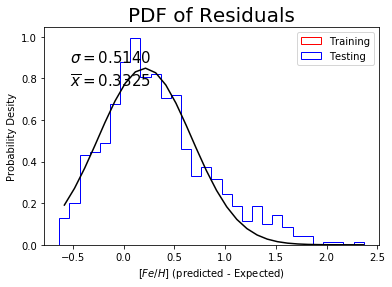

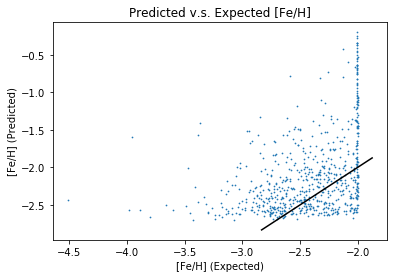

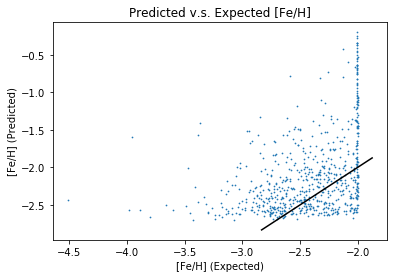

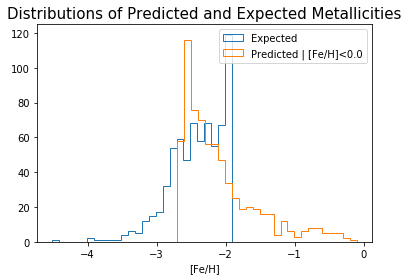

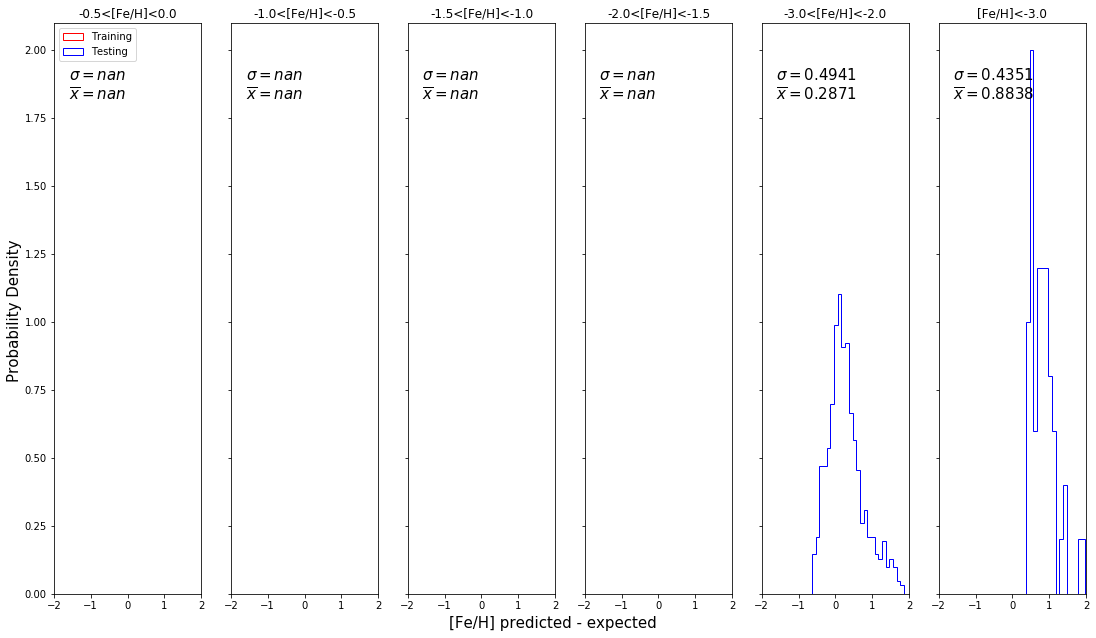


Data saved



In [9]:
#keep track of previous outputSDSS 
outputY = ver.data#[ver.data['logg']>3.5]

outputY = outputY.sample(frac = 1).reset_index()
if norm:
    x = pd.DataFrame()
    for col in fits.colours:
        x[col] = (outputY[col] - normParams[col][0])*1.0/normParams[col][1]
else:
    x = outputY[fits.colours]
outputY['FeH_pred'] = model.predict(x)
outputY['test_flag'] = 1
outputY['res'] = outputY['FeH_pred'] - outputY['FeHadop']
plotRes(outputY['res'],[]).show()
makePlots(outputY, adop = 'FeHadop')
save_data(outputY, 'youtput.ascii')


In [11]:
purY, comY = psMetric(outputY, inc = inc)
print printTable(inc, purY, comY)
print len(outputY[(outputY['FeHadop']==-2)])
#print len(outputYoutoutY['FeHadop'])

| [Fe/H]< | purity | completness |
----------------------------------
| -1.0    | 1.0000 | 0.9394      |
| -1.5    | 1.0000 | 0.8600      |
| -2.0    | 1.0000 | 0.6941      |
| -2.5    | 0.5754 | 0.3887      |
| -3.0    | -1.000 | 0.0000      |

25
693


In [ ]:
makePlots(outputSDSS[outputSDSS['test_flag']==1])
purTEST, comTEST = psMetric(outputSDSS[outputSDSS['test_flag']==1], inc = inc)
print printTable(inc, purTEST, comTEST) 


=

## Second NN  training on youakim 



In [ ]:
params2 = {
    'hidden_layer_sizes' : (32,32,32,32,32,32,32,32,32),
    'batch_size' : 20,
    'verbose' : False,
    'tol' : 0.000001,
    'verbose' : True
}

model2 = MLPRegressor(**params2)
ydata = outputY
yin_train, yin_test, yout_train, yout_test = train_test_split(ydata[fits.colours], ydata[fits.outputs], test_size = 0.2)
model2.fit(yin_train, np.ravel(yout_train))
outputY['test_flag2'] = [1]*len(yin_train)+[0]*len(yin_test)
outputY['pred2'] = model2.predict(outputY[fits.colours])
outputY['res2'] = outputY['pred2'] - outputY['FeHadop']

In [ ]:
makePlots(outputY,res = 'res2', pred = 'pred2', adop = 'FeHadop')